# Basic Data Manipulation & Visualization
--------------------------------------------------------------------
# ATT&CK Tactic: Lateral Movement
## Goals:
------------
* Show basic ES join queries
* Learn a little bit of Pandas
* Learn how to use matplotlib
* Learn Nodes and Edges format for a Network Graph


# Import Modules

In [1]:
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Image

# Hunting for

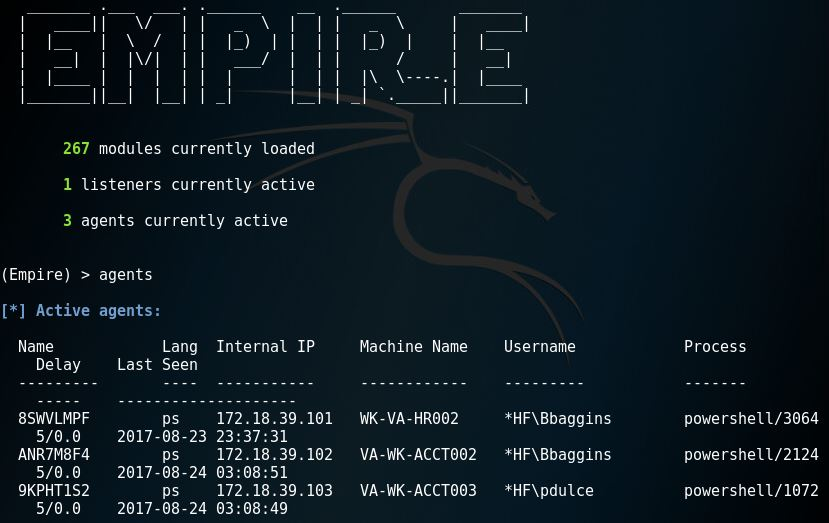

In [2]:
display(Image('../../Images/LM_Basic_Shells.jpg'))

# Connect to your ES via SSH Tunnel

In [3]:
es = Elasticsearch(['127.0.0.1'], port=9200, timeout=480)

## Query your ES for Successful Authentication Logs

In [4]:
successful_logon_query=es.search(index='winlogbeat-*', 
    body = {
        'size': 10000,
        'query': {
            'bool': {
               'must': [
                    {"match" : {'source_name': "Microsoft-Windows-Security-Auditing" }},
                    {"match": {'event_id': 4624}},
                    {"match": {'event_data.LogonType': 3}}
               ],
               'must_not': [
                    {"match" : {'event_data.IpAddress': "::1" }},
                    {"match": {'event_data.TargetUserName': "ANONYMOUS LOGON"}}
               ],
               "filter": [
                    {"range" : {"@timestamp" : {"gt": "now-4d", "lt" : "now"}}}
               ]    
            }

        }
    })

## Query your ES for Sysmon Network Logs

In [5]:
sysmon_network_query=es.search(index='winlogbeat-*', body = {
    'size': 10000,
    'query': {
        'bool': {
           'must': [
               {"match": {'source_name': 'Microsoft-Windows-Sysmon'}},
               {"match": {'event_id': 3}}
           ],
           'must_not': [
               {"match" : {'event_data.User': "NT AUTHORITY\SYSTEM"}}
           ],
           "filter": [
                {"range" : {"@timestamp" : {"gt": "now-4d", "lt" : "now"}}}
           ]    
        }
        
    }
})

# Normalize JSON (results) data into a DataFrame

In [6]:
sl_normalized=json_normalize(map(lambda x: x["_source"],successful_logon_query['hits']['hits']))
sn_normalized=json_normalize(map(lambda x: x["_source"],sysmon_network_query['hits']['hits']))

In [7]:
sl_normalized.head(5)

,@timestamp,@version,beat.hostname,beat.name,beat.version,computer_name,event_data.AuthenticationPackageName,event_data.ImpersonationLevel,event_data.IpAddress,event_data.IpPort,...,opcode,process_id,provider_guid,record_number,source_name,tags,task,thread_id,type,version
0,2017-08-23T16:08:41.770Z,1,VA-WK-HR001,VA-WK-HR001,5.2.1,VA-WK-HR001.hf.com,Kerberos,NaN,-,-,...,Info,492,{54849625-5478-4994-A5BA-3E3B0328C30D},265922,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,400,wineventlog,NaN
1,2017-08-23T00:59:57.432Z,1,HFDC01,HFDC01,5.5.0,HFDC01.hf.com,Kerberos,%%1840,fe80::2036:13d7:5626:b29b,61354,...,Info,484,{54849625-5478-4994-A5BA-3E3B0328C30D},8837698,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,4908,wineventlog,1.0
2,2017-08-23T00:24:56.830Z,1,HFDC01,HFDC01,5.5.0,HFDC01.hf.com,Kerberos,%%1833,fe80::2036:13d7:5626:b29b,61250,...,Info,484,{54849625-5478-4994-A5BA-3E3B0328C30D},8836390,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,316,wineventlog,1.0
3,2017-08-23T00:25:13.965Z,1,HFDC01,HFDC01,5.5.0,HFDC01.hf.com,Kerberos,%%1833,fe80::2036:13d7:5626:b29b,61253,...,Info,484,{54849625-5478-4994-A5BA-3E3B0328C30D},8836396,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,316,wineventlog,1.0
4,2017-08-23T00:29:57.020Z,1,HFDC01,HFDC01,5.5.0,HFDC01.hf.com,Kerberos,%%1833,fe80::2036:13d7:5626:b29b,61265,...,Info,484,{54849625-5478-4994-A5BA-3E3B0328C30D},8836435,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,316,wineventlog,1.0


In [8]:
sn_normalized.head(5)

,@timestamp,@version,beat.hostname,beat.name,beat.version,computer_name,event_data.DestinationHostname,event_data.DestinationIp,event_data.DestinationIsIpv6,event_data.DestinationPort,...,source_name,tags,task,thread_id,type,user.domain,user.identifier,user.name,user.type,version
0,2017-08-24T03:21:49.107Z,1,VA-WK-ACCT002,VA-WK-ACCT002,5.5.0,VA-WK-ACCT002.hf.com,WK-VA-HR002,172.18.39.105,false,80,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,1948,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5
1,2017-08-24T03:22:08.073Z,1,VA-WK-ACCT002,VA-WK-ACCT002,5.5.0,VA-WK-ACCT002.hf.com,WK-VA-HR002,172.18.39.105,false,80,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,1948,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5
2,2017-08-24T03:22:21.813Z,1,VA-WK-ACCT002,VA-WK-ACCT002,5.5.0,VA-WK-ACCT002.hf.com,WK-VA-HR002,172.18.39.105,false,80,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,1948,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5
3,2017-08-24T03:22:41.786Z,1,VA-WK-ACCT002,VA-WK-ACCT002,5.5.0,VA-WK-ACCT002.hf.com,WK-VA-HR002,172.18.39.105,false,80,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,1948,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5
4,2017-08-24T03:22:48.016Z,1,VA-WK-ACCT002,VA-WK-ACCT002,5.5.0,VA-WK-ACCT002.hf.com,WK-VA-HR002,172.18.39.105,false,80,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,1948,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5


# Clean Successful Logon DataFrame

In [9]:
sl_df=sl_normalized[sl_normalized["event_data.IpAddress"].str.contains('^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$')]
sl_df=sl_df[~sl_df['event_data.TargetUserName'].str.contains('.*\$')]
sl_df['user'] = sl_df['event_data.TargetDomainName'] + '\\' + sl_df['event_data.TargetUserName']
sl_df.rename(columns={"event_data.IpAddress":"sourceip", "computer_name":"target"}, inplace=True)
sl_df_clean=sl_df[['sourceip', 'target', 'user', '@timestamp']].reset_index(drop=True)
sl_df_clean.head(10)

,sourceip,target,user,@timestamp
0,172.18.39.102,HFDC01.hf.com,HF\gwhite,2017-08-23T15:14:34.934Z
1,172.18.39.103,HFDC01.hf.com,HF\shobbit,2017-08-23T15:16:52.111Z
2,172.18.39.101,HFDC01.hf.com,HF\Bbaggins,2017-08-23T14:48:47.058Z
3,172.18.39.100,HFDC01.hf.com,HF\cbrown,2017-08-23T13:50:44.437Z
4,172.18.39.103,HFDC01.hf.com,HF\shobbit,2017-08-23T13:52:57.620Z
5,172.18.39.101,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23T14:49:17.484Z
6,172.18.39.101,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23T14:56:18.915Z
7,172.18.39.102,VA-WK-ACCT003.hf.com,HF\pdulce,2017-08-23T15:28:01.492Z
8,172.18.39.102,VA-WK-ACCT003.hf.com,HF\pdulce,2017-08-23T15:12:34.046Z
9,172.18.39.103,HFDC01.hf.com,HF\shobbit,2017-08-23T14:33:01.250Z


# Clean Sysmon Network DataFrame

In [10]:
sn_df=sn_normalized[sn_normalized["event_data.SourceIp"].str.contains('^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$')]
sn_df.rename(columns={"event_data.SourceHostname":"source","event_data.SourceIp":"sourceip", "event_data.DestinationIp":"targetip", "event_data.User":"user"}, inplace=True)
sn_df_clean=sn_df[['source', 'targetip', 'user', '@timestamp']]
sn_df_clean.reset_index(drop=True)
sn_df_clean.head(10)

,source,targetip,user,@timestamp
0,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:21:49.107Z
1,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:08.073Z
2,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:21.813Z
3,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:41.786Z
4,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:48.016Z
5,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:00.495Z
6,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:07.022Z
7,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:31.053Z
8,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:18.889Z
9,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:14.142Z


# Create an IP-Computer Map with Sysmon Network Logs

In [11]:
sysmon_ip_computer_reference=sn_df[['sourceip', 'computer_name']]
sysmon_ip_computer_reference = (sysmon_ip_computer_reference.drop_duplicates()).reset_index(drop=True)
sysmon_ip_computer_reference

,sourceip,computer_name
0,172.18.39.102,VA-WK-ACCT002.hf.com
1,172.18.39.103,VA-WK-ACCT003.hf.com
2,172.18.39.101,WK-VA-HR002.hf.com
3,172.18.39.100,VA-WK-HR001.hf.com


# Merge Successful Logon DF and IP-Computer Map

In [12]:
sl_df_merged=pd.merge(sl_df_clean,sysmon_ip_computer_reference,how="left",left_on="sourceip",right_on="sourceip")
sl_df_merged.head(10)

,sourceip,target,user,@timestamp,computer_name
0,172.18.39.102,HFDC01.hf.com,HF\gwhite,2017-08-23T15:14:34.934Z,VA-WK-ACCT002.hf.com
1,172.18.39.103,HFDC01.hf.com,HF\shobbit,2017-08-23T15:16:52.111Z,VA-WK-ACCT003.hf.com
2,172.18.39.101,HFDC01.hf.com,HF\Bbaggins,2017-08-23T14:48:47.058Z,WK-VA-HR002.hf.com
3,172.18.39.100,HFDC01.hf.com,HF\cbrown,2017-08-23T13:50:44.437Z,VA-WK-HR001.hf.com
4,172.18.39.103,HFDC01.hf.com,HF\shobbit,2017-08-23T13:52:57.620Z,VA-WK-ACCT003.hf.com
5,172.18.39.101,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23T14:49:17.484Z,WK-VA-HR002.hf.com
6,172.18.39.101,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23T14:56:18.915Z,WK-VA-HR002.hf.com
7,172.18.39.102,VA-WK-ACCT003.hf.com,HF\pdulce,2017-08-23T15:28:01.492Z,VA-WK-ACCT002.hf.com
8,172.18.39.102,VA-WK-ACCT003.hf.com,HF\pdulce,2017-08-23T15:12:34.046Z,VA-WK-ACCT002.hf.com
9,172.18.39.103,HFDC01.hf.com,HF\shobbit,2017-08-23T14:33:01.250Z,VA-WK-ACCT003.hf.com


# Merge Sysmon Network DF and IP-Computer Map

In [13]:
sn_df_merged=pd.merge(sn_df_clean,sysmon_ip_computer_reference,how="left",left_on="targetip",right_on="sourceip")
sn_df_merged.head(10)

,source,targetip,user,@timestamp,sourceip,computer_name
0,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:21:49.107Z,NaN,NaN
1,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:08.073Z,NaN,NaN
2,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:21.813Z,NaN,NaN
3,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:41.786Z,NaN,NaN
4,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:48.016Z,NaN,NaN
5,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:00.495Z,NaN,NaN
6,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:07.022Z,NaN,NaN
7,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:31.053Z,NaN,NaN
8,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:18.889Z,NaN,NaN
9,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:14.142Z,NaN,NaN


# Map IP-Computer in Successful Logon Dataframe

In [14]:
sl_df_resolved=sl_df_merged[['computer_name','target', 'user', '@timestamp']][sl_df_merged['computer_name'].notnull()]
sl_df_resolved.rename(columns={'computer_name':"source"}, inplace=True)
sl_df_resolved.reset_index(drop=True)
sl_df_resolved.head(10)

,source,target,user,@timestamp
0,VA-WK-ACCT002.hf.com,HFDC01.hf.com,HF\gwhite,2017-08-23T15:14:34.934Z
1,VA-WK-ACCT003.hf.com,HFDC01.hf.com,HF\shobbit,2017-08-23T15:16:52.111Z
2,WK-VA-HR002.hf.com,HFDC01.hf.com,HF\Bbaggins,2017-08-23T14:48:47.058Z
3,VA-WK-HR001.hf.com,HFDC01.hf.com,HF\cbrown,2017-08-23T13:50:44.437Z
4,VA-WK-ACCT003.hf.com,HFDC01.hf.com,HF\shobbit,2017-08-23T13:52:57.620Z
5,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23T14:49:17.484Z
6,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23T14:56:18.915Z
7,VA-WK-ACCT002.hf.com,VA-WK-ACCT003.hf.com,HF\pdulce,2017-08-23T15:28:01.492Z
8,VA-WK-ACCT002.hf.com,VA-WK-ACCT003.hf.com,HF\pdulce,2017-08-23T15:12:34.046Z
9,VA-WK-ACCT003.hf.com,HFDC01.hf.com,HF\shobbit,2017-08-23T14:33:01.250Z


# Map IP-Computer in Sysmon Network Dataframe

In [15]:
sn_df_merged.computer_name.fillna(sn_df_merged.targetip, inplace=True)
sn_df_resolved=sn_df_merged[['source','computer_name', 'user', '@timestamp']]
sn_df_resolved.rename(columns={'computer_name':'target'}, inplace=True)
sn_df_resolved.head(10)

,source,target,user,@timestamp
0,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:21:49.107Z
1,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:08.073Z
2,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:21.813Z
3,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:41.786Z
4,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:48.016Z
5,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:00.495Z
6,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:07.022Z
7,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:31.053Z
8,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:18.889Z
9,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:23:14.142Z


# Stack Successful Logon and Sysmon Network DFs

In [16]:
sl_sn_appended = sl_df_resolved.append(sn_df_resolved)
sl_sn_appended = sl_sn_appended[['source', 'target', 'user']]
sl_sn_appended = (sl_sn_appended.drop_duplicates()).reset_index(drop=True)
sl_sn_appended

,source,target,user
0,VA-WK-ACCT002.hf.com,HFDC01.hf.com,HF\gwhite
1,VA-WK-ACCT003.hf.com,HFDC01.hf.com,HF\shobbit
2,WK-VA-HR002.hf.com,HFDC01.hf.com,HF\Bbaggins
3,VA-WK-HR001.hf.com,HFDC01.hf.com,HF\cbrown
4,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins
5,VA-WK-ACCT002.hf.com,VA-WK-ACCT003.hf.com,HF\pdulce
6,VA-WK-ACCT002.hf.com,HFDC01.hf.com,HF\pdulce
7,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins
8,VA-WK-ACCT003.hf.com,172.18.39.105,HF\pdulce
9,VA-WK-ACCT002.hf.com,65.52.108.154,HF\gwhite


# Take Successful Logon DF and merge it with Sysmon Network DF

In [17]:
sl_sn_merged = pd.merge(sl_df_resolved,sn_df_resolved,how="left",left_on="target",right_on="source")
sl_sn_merged.head(10)

,source_x,target_x,user_x,@timestamp_x,source_y,target_y,user_y,@timestamp_y
0,VA-WK-ACCT002.hf.com,HFDC01.hf.com,HF\gwhite,2017-08-23T15:14:34.934Z,NaN,NaN,NaN,NaN
1,VA-WK-ACCT003.hf.com,HFDC01.hf.com,HF\shobbit,2017-08-23T15:16:52.111Z,NaN,NaN,NaN,NaN
2,WK-VA-HR002.hf.com,HFDC01.hf.com,HF\Bbaggins,2017-08-23T14:48:47.058Z,NaN,NaN,NaN,NaN
3,VA-WK-HR001.hf.com,HFDC01.hf.com,HF\cbrown,2017-08-23T13:50:44.437Z,NaN,NaN,NaN,NaN
4,VA-WK-ACCT003.hf.com,HFDC01.hf.com,HF\shobbit,2017-08-23T13:52:57.620Z,NaN,NaN,NaN,NaN
5,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23T14:49:17.484Z,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:21:49.107Z
6,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23T14:49:17.484Z,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:08.073Z
7,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23T14:49:17.484Z,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:21.813Z
8,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23T14:49:17.484Z,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:41.786Z
9,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23T14:49:17.484Z,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-24T03:22:48.016Z


# Use TIME to start looking for a few suspicious (Successful Auth & Sysmon Network Calls)

In [18]:
sl_sn_merged['@timestamp_x'] = pd.to_datetime(sl_sn_merged['@timestamp_x'])
sl_sn_merged['@timestamp_y'] = pd.to_datetime(sl_sn_merged['@timestamp_y'])

sl_sn_merged = sl_sn_merged[sl_sn_merged.apply(lambda x: (x['@timestamp_y'] - x['@timestamp_x']) < pd.Timedelta("280sec") and x['user_y'] == x['user_x'], axis=1)]

In [19]:
sl_sn_merged

,source_x,target_x,user_x,@timestamp_x,source_y,target_y,user_y,@timestamp_y
2243,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23 14:56:18.915,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-23 14:58:38.901
2244,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23 14:56:18.915,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-23 14:59:18.772
2245,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23 14:56:18.915,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-23 14:57:05.445
2246,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23 14:56:18.915,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-23 14:57:15.928
2247,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23 14:56:18.915,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-23 14:57:20.808
2248,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23 14:56:18.915,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-23 14:57:25.680
2249,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23 14:56:18.915,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-23 14:59:47.640
2250,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23 14:56:18.915,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-23 15:00:23.267
2251,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23 14:56:18.915,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-23 15:00:33.162
2425,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,2017-08-23 14:56:18.915,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,2017-08-23 14:56:59.610


# Grab suspicious Successful Logon activity

In [20]:
sl_df_split = sl_sn_merged[['source_x', 'target_x', 'user_x']]
sl_df_split.rename(columns={'source_x':'source', 'target_x':'target', 'user_x':'user'}, inplace=True)
sl_df_split = (sl_df_split.drop_duplicates()).reset_index(drop=True)
sl_df_split

,source,target,user
0,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins
1,VA-WK-ACCT002.hf.com,VA-WK-ACCT003.hf.com,HF\pdulce


# Grab suspicious Sysmon Network activity

In [21]:
sn_df_split = sl_sn_merged[['source_y', 'target_y', 'user_y']]
sn_df_split.rename(columns={'source_y':'source', 'target_y':'target', 'user_y':'user'}, inplace=True)
sn_df_split = (sn_df_split.drop_duplicates()).reset_index(drop=True)
sn_df_split

,source,target,user
0,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins
1,VA-WK-ACCT003.hf.com,172.18.39.105,HF\pdulce


# Stack suspicious Successful Logon and Sysmon Network DFs

In [22]:
sl_sn_split_appended = sl_df_split.append(sn_df_split)
sl_sn_split_appended['label'] = '1'
sl_sn_split_appended

,source,target,user,label
0,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,1
1,VA-WK-ACCT002.hf.com,VA-WK-ACCT003.hf.com,HF\pdulce,1
0,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,1
1,VA-WK-ACCT003.hf.com,172.18.39.105,HF\pdulce,1


# Merge suspicious DF with Clean Stacked Successful Logon and Sysmon Network DFs

In [23]:
src_dst_merged = pd.merge(sl_sn_appended,sl_sn_split_appended,how="left",left_on=["source","target", "user"],right_on=["source","target", "user"])
src_dst_merged

,source,target,user,label
0,VA-WK-ACCT002.hf.com,HFDC01.hf.com,HF\gwhite,NaN
1,VA-WK-ACCT003.hf.com,HFDC01.hf.com,HF\shobbit,NaN
2,WK-VA-HR002.hf.com,HFDC01.hf.com,HF\Bbaggins,NaN
3,VA-WK-HR001.hf.com,HFDC01.hf.com,HF\cbrown,NaN
4,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,1
5,VA-WK-ACCT002.hf.com,VA-WK-ACCT003.hf.com,HF\pdulce,1
6,VA-WK-ACCT002.hf.com,HFDC01.hf.com,HF\pdulce,NaN
7,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,1
8,VA-WK-ACCT003.hf.com,172.18.39.105,HF\pdulce,1
9,VA-WK-ACCT002.hf.com,65.52.108.154,HF\gwhite,NaN


# Add label 0 to the rest of the rows

In [24]:
src_dst = src_dst_merged.fillna('0')
src_dst

,source,target,user,label
0,VA-WK-ACCT002.hf.com,HFDC01.hf.com,HF\gwhite,0
1,VA-WK-ACCT003.hf.com,HFDC01.hf.com,HF\shobbit,0
2,WK-VA-HR002.hf.com,HFDC01.hf.com,HF\Bbaggins,0
3,VA-WK-HR001.hf.com,HFDC01.hf.com,HF\cbrown,0
4,WK-VA-HR002.hf.com,VA-WK-ACCT002.hf.com,HF\Bbaggins,1
5,VA-WK-ACCT002.hf.com,VA-WK-ACCT003.hf.com,HF\pdulce,1
6,VA-WK-ACCT002.hf.com,HFDC01.hf.com,HF\pdulce,0
7,VA-WK-ACCT002.hf.com,172.18.39.105,HF\Bbaggins,1
8,VA-WK-ACCT003.hf.com,172.18.39.105,HF\pdulce,1
9,VA-WK-ACCT002.hf.com,65.52.108.154,HF\gwhite,0


# Start Creating a Node list with all systems (Source & Target)

In [25]:
computers = pd.Index(src_dst['source'].append(src_dst['target']).reset_index(drop=True).unique())
computers

Index([u'VA-WK-ACCT002.hf.com', u'VA-WK-ACCT003.hf.com', u'WK-VA-HR002.hf.com',
       u'VA-WK-HR001.hf.com', u'HFDC01.hf.com', u'172.18.39.105',
       u'65.52.108.154', u'65.55.252.71', u'172.18.39.104', u'40.117.100.83',
       u'13.107.3.128', u'13.107.5.88', u'40.121.144.182'],
      dtype='object')

# Start creating a Link list (Source to target)

In [26]:
temp_links_list = list(src_dst.apply(lambda row: {"source": row['source'], "target": row['target'], "user": row['user'], "label": row['label']}, axis=1))
temp_links_list

[{'label': '0',
  'source': u'VA-WK-ACCT002.hf.com',
  'target': u'HFDC01.hf.com',
  'user': u'HF\\gwhite'},
 {'label': '0',
  'source': u'VA-WK-ACCT003.hf.com',
  'target': u'HFDC01.hf.com',
  'user': u'HF\\shobbit'},
 {'label': '0',
  'source': u'WK-VA-HR002.hf.com',
  'target': u'HFDC01.hf.com',
  'user': u'HF\\Bbaggins'},
 {'label': '0',
  'source': u'VA-WK-HR001.hf.com',
  'target': u'HFDC01.hf.com',
  'user': u'HF\\cbrown'},
 {'label': '1',
  'source': u'WK-VA-HR002.hf.com',
  'target': u'VA-WK-ACCT002.hf.com',
  'user': u'HF\\Bbaggins'},
 {'label': '1',
  'source': u'VA-WK-ACCT002.hf.com',
  'target': u'VA-WK-ACCT003.hf.com',
  'user': u'HF\\pdulce'},
 {'label': '0',
  'source': u'VA-WK-ACCT002.hf.com',
  'target': u'HFDC01.hf.com',
  'user': u'HF\\pdulce'},
 {'label': '1',
  'source': u'VA-WK-ACCT002.hf.com',
  'target': u'172.18.39.105',
  'user': u'HF\\Bbaggins'},
 {'label': '1',
  'source': u'VA-WK-ACCT003.hf.com',
  'target': u'172.18.39.105',
  'user': u'HF\\pdulce'},
 {'l

# Prepare your Link List

In [27]:
links = []
for link in temp_links_list:
    record = {"user":link['user'],"label":link['label'], "source":computers.get_loc(link['source']), "target":computers.get_loc(link['target'])}
    links.append(record)

In [28]:
links

[{'label': '0', 'source': 0, 'target': 4, 'user': u'HF\\gwhite'},
 {'label': '0', 'source': 1, 'target': 4, 'user': u'HF\\shobbit'},
 {'label': '0', 'source': 2, 'target': 4, 'user': u'HF\\Bbaggins'},
 {'label': '0', 'source': 3, 'target': 4, 'user': u'HF\\cbrown'},
 {'label': '1', 'source': 2, 'target': 0, 'user': u'HF\\Bbaggins'},
 {'label': '1', 'source': 0, 'target': 1, 'user': u'HF\\pdulce'},
 {'label': '0', 'source': 0, 'target': 4, 'user': u'HF\\pdulce'},
 {'label': '1', 'source': 0, 'target': 5, 'user': u'HF\\Bbaggins'},
 {'label': '1', 'source': 1, 'target': 5, 'user': u'HF\\pdulce'},
 {'label': '0', 'source': 0, 'target': 6, 'user': u'HF\\gwhite'},
 {'label': '0', 'source': 2, 'target': 7, 'user': u'HF\\Bbaggins'},
 {'label': '0', 'source': 2, 'target': 5, 'user': u'HF\\Bbaggins'},
 {'label': '0', 'source': 1, 'target': 8, 'user': u'HF\\pdulce'},
 {'label': '0', 'source': 0, 'target': 1, 'user': u'HF\\Bbaggins'},
 {'label': '0', 'source': 1, 'target': 3, 'user': u'HF\\pdulce'

# Finalize your Node list

In [29]:
nodes = []
for c in computers:
    nodes.append({"id":c})

In [30]:
nodes

[{'id': u'VA-WK-ACCT002.hf.com'},
 {'id': u'VA-WK-ACCT003.hf.com'},
 {'id': u'WK-VA-HR002.hf.com'},
 {'id': u'VA-WK-HR001.hf.com'},
 {'id': u'HFDC01.hf.com'},
 {'id': u'172.18.39.105'},
 {'id': u'65.52.108.154'},
 {'id': u'65.55.252.71'},
 {'id': u'172.18.39.104'},
 {'id': u'40.117.100.83'},
 {'id': u'13.107.3.128'},
 {'id': u'13.107.5.88'},
 {'id': u'40.121.144.182'}]

# Add your nodes and links and create a dictionary

In [31]:
json_network = {"nodes":nodes, "links":links}
json_network.keys()

['nodes', 'links']

# Convert dictionary into JSON format

In [32]:
import json
json_dump = json.dumps(json_network, indent=1, sort_keys=True)
print(json_dump)

{
 "links": [
  {
   "label": "0", 
   "source": 0, 
   "target": 4, 
   "user": "HF\\gwhite"
  }, 
  {
   "label": "0", 
   "source": 1, 
   "target": 4, 
   "user": "HF\\shobbit"
  }, 
  {
   "label": "0", 
   "source": 2, 
   "target": 4, 
   "user": "HF\\Bbaggins"
  }, 
  {
   "label": "0", 
   "source": 3, 
   "target": 4, 
   "user": "HF\\cbrown"
  }, 
  {
   "label": "1", 
   "source": 2, 
   "target": 0, 
   "user": "HF\\Bbaggins"
  }, 
  {
   "label": "1", 
   "source": 0, 
   "target": 1, 
   "user": "HF\\pdulce"
  }, 
  {
   "label": "0", 
   "source": 0, 
   "target": 4, 
   "user": "HF\\pdulce"
  }, 
  {
   "label": "1", 
   "source": 0, 
   "target": 5, 
   "user": "HF\\Bbaggins"
  }, 
  {
   "label": "1", 
   "source": 1, 
   "target": 5, 
   "user": "HF\\pdulce"
  }, 
  {
   "label": "0", 
   "source": 0, 
   "target": 6, 
   "user": "HF\\gwhite"
  }, 
  {
   "label": "0", 
   "source": 2, 
   "target": 7, 
   "user": "HF\\Bbaggins"
  }, 
  {
   "label": "0", 
   "sourc

# Export it to a JSON file

In [33]:
filename = 'LM_Basic_Behavior.json'
json_out = open(filename,'w')
json_out.write(json_dump)
json_out.close()

# Bonus: Use Matplotlib to build a basic nework graph

In [34]:
indices_network = nx.from_pandas_dataframe(src_dst, 'source', 'target', 'user')

In [35]:
i = nx.degree(indices_network)
i

{u'13.107.3.128': 1,
 u'13.107.5.88': 1,
 u'172.18.39.104': 1,
 u'172.18.39.105': 3,
 u'40.117.100.83': 1,
 u'40.121.144.182': 1,
 u'65.52.108.154': 2,
 u'65.55.252.71': 1,
 u'HFDC01.hf.com': 4,
 u'VA-WK-ACCT002.hf.com': 5,
 u'VA-WK-ACCT003.hf.com': 6,
 u'VA-WK-HR001.hf.com': 6,
 u'WK-VA-HR002.hf.com': 4}

In [36]:
nx.draw(indices_network, with_labels=True, graph_layout='shell', nodelist=i.keys(), node_size=[v*60 for v in i.values()])

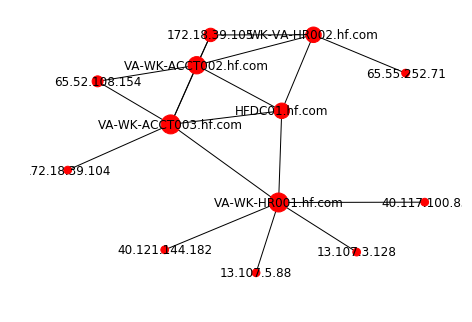

In [37]:
plt.show()